## This answer is outdated in favor of santa_cruz_vegetation_stac.
Using NDVI, what is the average total area of “barren” (barren rock, sand, or snow) land for the Santa Cruz province of Argentina for the month of November, 2020.

In [1]:
import requests
import zipfile
import os
import geopandas as gpd
import numpy as np
from shapely.geometry import mapping, box, Polygon
import earthaccess
import xarray as xr
import pandas as pd
import h5py
from osgeo import gdal
import rasterio
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import rioxarray as rxr

import earthpy as et
import earthpy.spatial as es
import earthpy.plot as ep

/Users/nick/anaconda3/envs/gis/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
country = "Argentina"
province = "Santa Cruz"

#### Get states/provinces shapes

In [3]:
if not os.path.exists('data/states_provinces'):
  url = 'https://naturalearth.s3.amazonaws.com/10m_cultural/ne_10m_admin_1_states_provinces.zip'
  r = requests.get(url, allow_redirects=True)
  name = 'states_provinces.zip'
  open('data/'+name, 'wb').write(r.content)
  with zipfile.ZipFile('data/states_provinces.zip', 'r') as zip_ref:
    zip_ref.extractall('data/states_provinces')
  os.remove('data/states_provinces.zip')
else:
  print("Skipping")

Skipping


In [4]:
provinces = gpd.read_file("./data/states_provinces/ne_10m_admin_1_states_provinces.shp")

In [5]:
# Find Santa Cruz in the dataset
scdf = provinces.loc[(provinces['name'] == province) & (provinces['admin'] == country)]
scdf = scdf.reset_index(drop=True)

<Axes: >

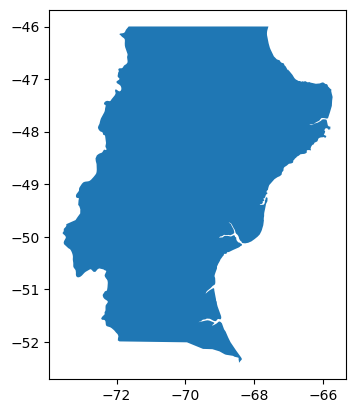

In [6]:
scdf.plot()

In [7]:
sc_shape = scdf.at[0,'geometry']

----

## Get NDVI Data

"The Terra Moderate Resolution Imaging Spectroradiometer (MODIS) Vegetation Indices Monthly (MOD13C2) Version 6.1 product provides a Vegetation Index (VI) value at a per pixel basis. There are two primary vegetation layers. The first is the Normalized Difference Vegetation Index (NDVI) which is referred to as the continuity index to the existing National Oceanic and Atmospheric Administration-Advanced Very High Resolution Radiometer (NOAA-AVHRR) derived NDVI. The second vegetation layer is the Enhanced Vegetation Index (EVI), which has improved sensitivity over high biomass regions.

The Climate Modeling Grid (CMG) consists of 3,600 rows and 7,200 columns of 5,600 meter (m) pixels. In generating this monthly product, the algorithm ingests all the MOD13A2 products that overlap the month and employs a weighted temporal average. Global MOD13C2 data are cloud-free spatial composites and are provided as a Level 3 product projected on a 0.05 degree (5,600 m) geographic CMG. The MOD13C2 has data fields for the NDVI, EVI, VI QA, reflectance data, angular information, and spatial statistics such as mean, standard deviation, and number of used input pixels at the 0.05 degree CMG resolution."

### Get from NASA EarthData

In [8]:
auth = earthaccess.login()

You're now authenticated with NASA Earthdata Login
Using token with expiration date: 10/04/2023
Using environment variables for EDL


In [9]:
results = earthaccess.search_data(
    short_name='MOD13C2',
    cloud_hosted=True,
    temporal=("2020-11-01", "2020-11-30"),
    count=1
)
results

Granules found: 1


[Collection: {'ShortName': 'MOD13C2', 'Version': '061'}
 Spatial coverage: {'HorizontalSpatialDomain': {'Geometry': {'BoundingRectangles': [{'WestBoundingCoordinate': -180.0, 'EastBoundingCoordinate': 180.0, 'NorthBoundingCoordinate': 90.0, 'SouthBoundingCoordinate': -90.0}]}}}
 Temporal coverage: {'RangeDateTime': {'BeginningDateTime': '2020-11-01T00:00:00.000Z', 'EndingDateTime': '2020-11-30T23:59:59.000Z'}}
 Size(MB): 89.4484
 Data: ['https://data.lpdaac.earthdatacloud.nasa.gov/lp-prod-protected/MOD13C2.061/MOD13C2.A2020306.061.2020357112600/MOD13C2.A2020306.061.2020357112600.hdf']]

In [10]:
# Download file to local
if not os.path.exists('data/ndvi/MOD13C2.A2020306.061.2020357112600.hdf'):
  files = earthaccess.download(results, "./data/ndvi")

In [11]:
# Open hdf in xarray using rioxarray
modis = rxr.open_rasterio('data/ndvi/MOD13C2.A2020306.061.2020357112600.hdf', masked=True)
modis

<xarray.Dataset>
Dimensions:                                   (band: 1, x: 7200, y: 3600)
Coordinates:
  * band                                      (band) int64 1
  * x                                         (x) float64 -180.0 ... 180.0
  * y                                         (y) float64 89.97 89.92 ... -89.98
    spatial_ref                               int64 0
Data variables: (12/13)
    CMG 0.05 Deg Monthly NDVI                 (band, y, x) float32 ...
    CMG 0.05 Deg Monthly EVI std dev          (band, y, x) float32 ...
    CMG 0.05 Deg Monthly #1km pix used        (band, y, x) float32 ...
    CMG 0.05 Deg Monthly #1km pix +-30deg VZ  (band, y, x) float32 ...
    CMG 0.05 Deg Monthly pixel reliability    (band, y, x) float32 ...
    CMG 0.05 Deg Monthly EVI                  (band, y, x) float32 ...
    ...                                        ...
    CMG 0.05 Deg Monthly red reflectance      (band, y, x) float32 ...
    CMG 0.05 Deg Monthly NIR reflectance      (band, y, x) float32 ...
    CMG 0.05 Deg Monthly blue reflectance     (band, y, x) float32 ...
    CMG 0.05 Deg Monthly MIR reflectance      (band, y, x) float32 ...
    CMG 0.05 Deg Monthly Avg sun zen angle    (band, y, x) float32 ...
    CMG 0.05 Deg Monthly NDVI std dev         (band, y, x) float32 ...
Attributes: (12/177)
    ALGORITHMPACKAGEACCEPTANCEDATE:      102004
    ALGORITHMPACKAGEMATURITYCODE:        Normal
    ALGORITHMPACKAGENAME:                MOD_PR13C2
    ALGORITHMPACKAGEVERSION:             5
    ASSOCIATEDINSTRUMENTSHORTNAME.1:     MODIS
    ASSOCIATEDPLATFORMSHORTNAME.1:       Terra
    ...                                  ...
    SNOWICEFLAGGED:                      YES
    SOUTHBOUNDINGCOORDINATE:             -90.0
    SPSOPARAMETERS:                      2749, 4334, 2749a, 4334a
    VERSIONID:                           61
    WESTBOUNDINGCOORDINATE:              -180.0
    ZONEIDENTIFIER:                      Other Grid System

### Select desired band (NDVI)

In [12]:
ndvi = modis['CMG 0.05 Deg Monthly NDVI']
ndvi

<xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' (band: 1, y: 3600, x: 7200)>
[25920000 values with dtype=float32]
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Attributes:
    add_offset:        0.0
    add_offset_err:    0
    calibrated_nt:     5
    long_name:         CMG 0.05 Deg Monthly NDVI
    scale_factor:      10000.0
    scale_factor_err:  0
    units:             NDVI
    valid_range:       -2000, 10000

### Clip to just Santa Cruz area

In [13]:
modis_clip = ndvi.rio.clip(scdf.geometry.apply(mapping), scdf.crs, drop=False, invert=False)
modis_clip

<xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' (band: 1, y: 3600, x: 7200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0
Attributes:
    add_offset:        0.0
    add_offset_err:    0
    calibrated_nt:     5
    long_name:         CMG 0.05 Deg Monthly NDVI
    scale_factor:      10000.0
    scale_factor_err:  0
    units:             NDVI
    valid_range:       -2000, 10000

In [14]:
# For mapping
states_provinces = cfeature.NaturalEarthFeature(
        category='cultural',
        name='admin_1_states_provinces',
        scale='10m',
        facecolor='none')
bounds = [-77.09276372561895,-63.54029983538979,-44.44687551389838,-53.59545491495126]

### Plot NVDI

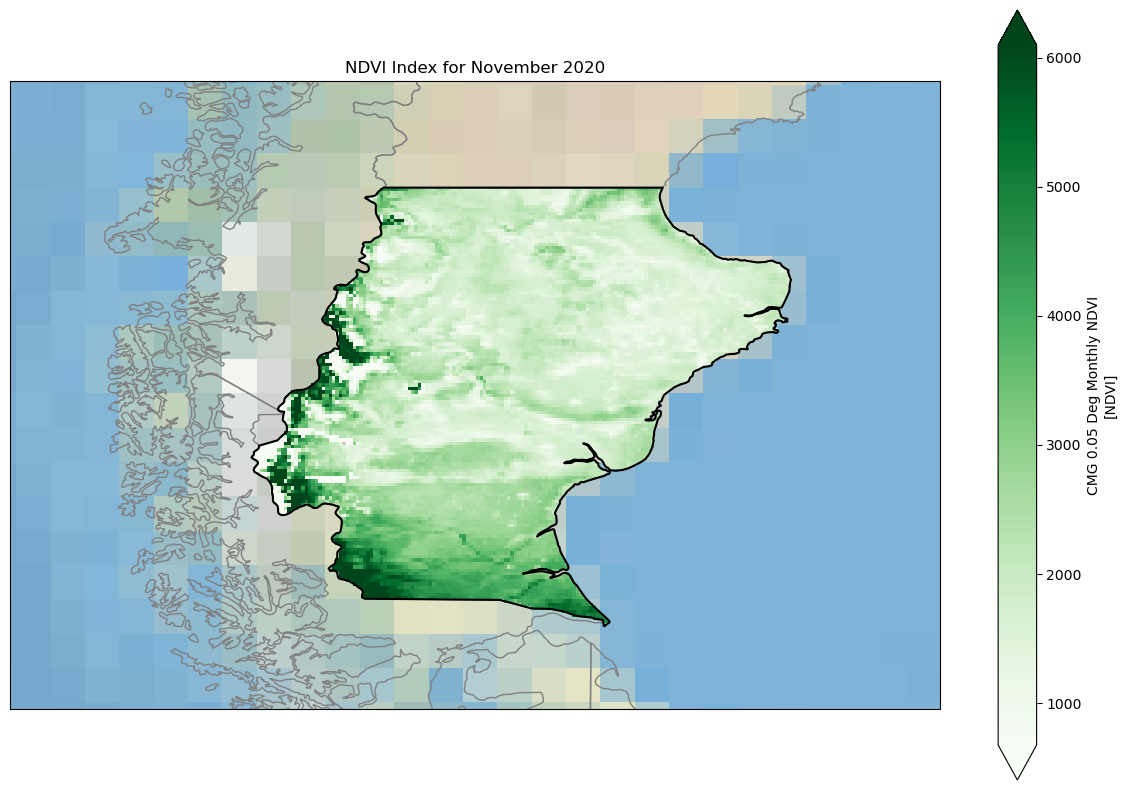

In [15]:
fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
modis_clip.plot(ax=ax,robust=True, cmap='Greens')

scdf.boundary.plot(ax=ax,color='black')
plt.title('NDVI Index for November 2020')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()

(array([  78.,  112., 1407., 6800., 2054.,  794.,  345.,  215.,   68.,
          15.]),
 array([-1892.        ,  -793.79998779,   304.3999939 ,  1402.59997559,
         2500.80004883,  3599.        ,  4697.20019531,  5795.39990234,
         6893.60009766,  7991.79980469,  9090.        ]),
 <BarContainer object of 10 artists>)

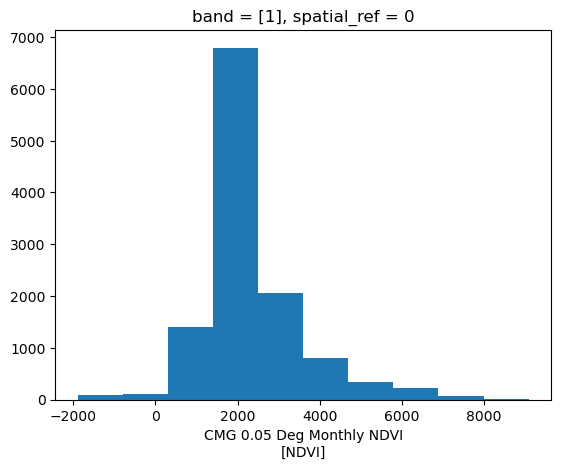

In [16]:
modis_clip.plot.hist()

----

The values from MODIS range from -2000 to 10000.

"NDVI values range from +1.0 to -1.0. Areas of barren rock, sand, or snow usually show very low NDVI values (for example, 0.1 or less). Sparse vegetation such as shrubs and grasslands or senescing crops may result in moderate NDVI values (approximately 0.2 to 0.5). High NDVI values (approximately 0.6 to 0.9) correspond to dense vegetation such as that found in temperate and tropical forests or crops at their peak growth stage."

So the data needs to be normalized to that scale.

### Normalize range (-1 to 1)

In [17]:
normalized_data = (modis_clip - modis_clip.min()) / (modis_clip.max() - modis_clip.min())  # Normalize to 0 to 1 range
normalized_data = (normalized_data * 2) - 1  # Normalize to -1 to 1 range

(array([  78.,  112., 1407., 6800., 2054.,  794.,  345.,  215.,   68.,
          15.]),
 array([-1. , -0.8, -0.6, -0.4, -0.2,  0. ,  0.2,  0.4,  0.6,  0.8,  1. ]),
 <BarContainer object of 10 artists>)

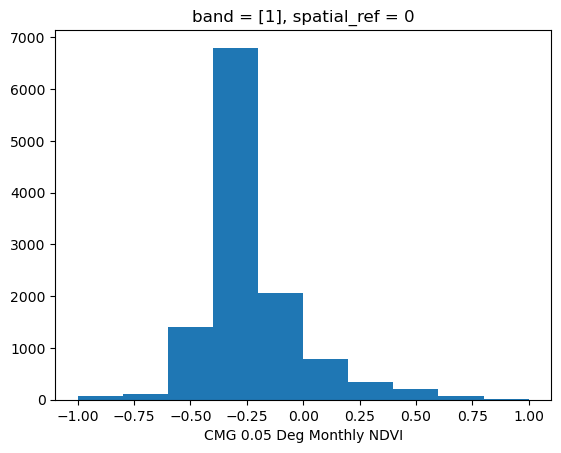

In [18]:
normalized_data.plot.hist()

### Clip to barren area (NDVI <= 0.1)

In [19]:
barren_area = normalized_data.where(normalized_data <= 0.1)

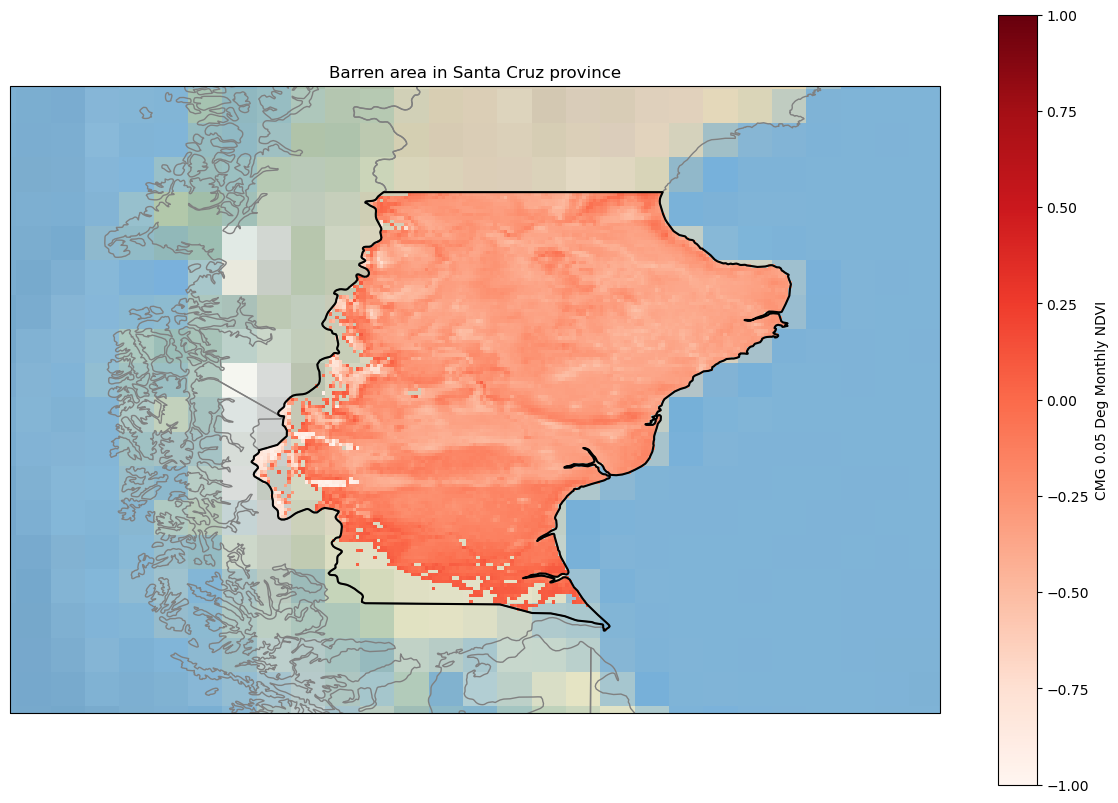

In [26]:
# clipped = barren_area.rio.clip(scdf.geometry.apply(mapping), scdf.crs, drop=False, invert=False)

fig=plt.figure(figsize=(15,10))
ax=fig.add_subplot(projection=ccrs.PlateCarree())
barren_area.plot(ax=ax, cmap='Reds')

scdf.boundary.plot(ax=ax,color='black')
plt.title('Barren area in Santa Cruz province')
ax.add_feature(states_provinces, edgecolor='gray')
ax.set_extent(bounds, crs=ccrs.PlateCarree())
ax.stock_img()

plt.show()

In [21]:
barren_area

<xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' (band: 1, y: 3600, x: 7200)>
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]])
Coordinates:
  * band         (band) int64 1
  * x            (x) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0
  * y            (y) float64 89.97 89.92 89.88 89.82 ... -89.88 -89.93 -89.98
    spatial_ref  int64 0

Issue: To sanity check my number, I looked up how big Santa Cruz is: 243,943 km2. Based on the map, the barren area should be only a little less than that. Based on the data from [MODIS13C2](https://lpdaac.usgs.gov/products/mod13c2v061/), each pixel is 5600m2. Unfortunately, when I do the math on my data, I get an area larger than the area of santa cruz, but the clipped data of all of santa cruz is also larger (but seems to have the correct difference)

In [22]:
def calculateArea(data):
    pixel_size_m2 = 5600**2

    # Step 2: Count the number of valid (non-missing) pixels
    valid_pixel_count = data.notnull().sum()
    print(valid_pixel_count)

    # Step 3: Calculate the total area covered in square meters
    total_area_m2 = valid_pixel_count * pixel_size_m2

    print("Total area covered:", total_area_m2 / 1000000, "square km")

In [23]:
calculateArea(barren_area)

<xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' ()>
array(10928)
Coordinates:
    spatial_ref  int64 0
Total area covered: <xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' ()>
array(342702.08)
Coordinates:
    spatial_ref  int64 0 square km


In [24]:
calculateArea(modis_clip)

<xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' ()>
array(11888)
Coordinates:
    spatial_ref  int64 0
Total area covered: <xarray.DataArray 'CMG 0.05 Deg Monthly NDVI' ()>
array(372807.68)
Coordinates:
    spatial_ref  int64 0 square km


To sanity check, calculating the area of the earth using the resolution and area of each pixel (real area is 509600000 km2)

In [25]:
(7200 * 3600) * 5600**2 / 1000000

812851200.0

Clearly 812 million km2 is too large